In [159]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import tensorflow as tf
import numpy as np
import pickle
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score
from datapipe import bin_ndarray, calcDff
from sklearn.externals import joblib
#TODO: read tf documentation on what the static_rnn does
#do I want to one hot encode the data? or already too many dimensions

In [2]:
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
np.random.seed(0)

In [4]:
tf.__version__
from tensorflow.python.ops import control_flow_ops

orig_while_loop = control_flow_ops.while_loop

def patched_while_loop(*args, **kwargs):
    kwargs.pop("maximum_iterations", None)  # Ignore.
    return orig_while_loop(*args, **kwargs)


control_flow_ops.while_loop = patched_while_loop

In [5]:
def process_dy(dy):
    (length, y, x) = dy.shape
    newdy = np.zeros((length, y-40, x-50), dtype=np.float16)
    for ind, image in enumerate(dy):
        newimg = image[1:-39, 0:-50]
        newdy[ind] = image[1:-39, 0:-50]
    print(newdy[0].shape)
    return bin_dy(newdy)
    # newdyfile = open('./dfy/cropped_AV_2.pkl', 'wb')
#     np.save('./data/cropped_AV_5.npy', newdy)

In [6]:
def bin_dy(dy):
    (length, y, x) = dy.shape
    print(dy.shape)
    newdy = np.zeros((length, int(y/2), int(x/2)), dtype=np.float16)
    for ind, image in enumerate(dy):
        newdy[ind] = bin_ndarray(image, (int(y/2), int(x/2)))
    # newdyfile = open('./dfy/bin_AV_2.pkl', 'wb')
    print(newdy.shape)
    return newdy

In [6]:
# #open files, they have not been normalized yet
# dffile = open('masdfr3m1170210s2.pkl',"rb")
# dyfile = open('r3m1170210s2.pkl', "rb")
# df = pickle.load(dffile)
# df = df.drop(columns='pupilCurr', axis=1)
# df = df.drop(columns='pupilPeri', axis=1)
# df = df.interpolate()
# dy = pickle.load(dyfile)
# #dataset2
# dffile = open('masdfr4m7170321s1.pkl',"rb")
# dyfile = open('r4m7170321s1.pkl', "rb")
# df = pickle.load(dffile)
# df = df.drop(columns='pupilCurr', axis=1)
# df = df.drop(columns='pupilPeri', axis=1)
# df = df.interpolate()
# dy = pickle.load(dyfile)

In [7]:
#loading full file on disk, can access small slices without loading into memory
dy = np.load('./data/dffAV_2.npy', mmap_mode='r')
# dy = process_dy(dy)
# dy = calcDff(dy, .2, 30)
f = open('./data/masdfAV_2.pkl', 'rb')
df = pickle.load(f)
(length, y, x) = dy.shape
print(length, x, y)

52478 295 300


In [ ]:
#load in encoders
# earEncoder
earEncoder = load('earEncoder.h5')
# eyeEncoder
eyeEncoder = load('eyeEncoder.h5')


In [70]:
#encodedwhisk dataset
whisk_encoded = np.load("./data/whisk_encoded_df.npy")

In [175]:
#10hz data
dfcropped = (df.iloc[::3])
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]

dycropped= (dy[::3])
(length, leny, lenx) = dycropped.shape
dycropped = dycropped.reshape(length, leny*lenx)

In [162]:
#15hz data
dfcropped = (df.iloc[::2])
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]

dycropped = (dy[::2])
(length, leny, lenx) = dycropped.shape
dycropped = dycropped.reshape(length, leny*lenx)

In [152]:
#30hz data 
dfcropped = df[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]
(length, leny, lenx) = dy.shape

dycropped = dy.reshape((length, leny*lenx))

In [227]:
print(dfcropped) # do I want to take out lastStimT ??

       stimType  pupilCurr  snoutCurr   jawCurr  wheelCurr  responseT    H  \
0          -1.0   0.174866   0.000000  0.000000   3.002167        0.0  0.0   
1          -1.0   0.149689   1.135922  2.008626   3.001709        0.0  0.0   
2          -1.0   0.145569   1.059639  1.910667   3.002014        0.0  0.0   
3          -1.0   0.149994   0.972261  1.818762   3.002167        0.0  0.0   
4          -1.0   0.149078   1.001387  1.615047   3.002167        0.0  0.0   
5          -1.0   0.143127   1.903745  2.294210   3.001862        0.0  0.0   
6          -1.0   0.149689   2.651872  1.808228   3.001862        0.0  0.0   
7          -1.0   0.147858   1.222469  2.060219   3.001709        0.0  0.0   
8          -1.0   0.143127   1.163107  1.768497   3.002014        0.0  0.0   
9          -1.0   0.146637   0.990707  3.043879   3.002319        0.0  0.0   
10         -1.0   0.147247   1.802497  3.995272   3.002472        0.0  0.0   
11         -1.0   0.144653   1.948128  5.999005   3.002014      

In [88]:
x_data = dfcropped.values
print(len(x_data))
print(whisk_encoded.shape)
whisk_encoded_reshape = whisk_encoded.reshape((17002, 14*34*16))
x_data = np.concatenate((x_data, whisk_encoded_reshape), axis=1)
print(type(x_data))
print("Shape:", x_data.shape)

17002
(17002, 14, 34, 16)
<class 'numpy.ndarray'>
Shape: (17002, 7629)


In [176]:
#no whisk 
x_data = dfcropped.values

In [177]:
print(type(dycropped))
print("Shape:", dycropped.shape)

<class 'numpy.core.memmap.memmap'>
Shape: (17493, 88500)


In [178]:
num_data = len(x_data)
print(num_data)
train_split = 0.7
validation_split = 0.1
num_train = int(train_split*num_data)
num_val = int((num_data - num_train)*validation_split)
num_test = num_data - num_train - num_val

17493


In [179]:
x_train = x_data[0:num_train]
x_val = x_data[num_train:(num_train+num_val)]
x_test = x_data[(num_train+num_val):]
len(x_train) + len(x_test)

16969

In [180]:
y_train = dycropped[0:num_train]
y_val = dycropped[num_train:(num_train+num_val)]
y_test = dycropped[(num_train+num_val):]
len(y_train) + len(y_test)
len(y_train) + len(y_test)

16969

In [181]:
num_x_signals = x_data.shape[1]
num_x_signals
num_y_signals = dycropped.shape[1]
num_y_signals

88500

# Scaled Data

In [182]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -289.9323419861777
Max: 40.64938735961914


In [183]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
joblib.dump(x_scaler, "x_scaler10hz.pkl")

['x_scaler10hz.pkl']

In [184]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [185]:
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)

In [186]:
x_test_scaled = x_scaler.transform(x_test)
x_val_scaled = x_scaler.transform(x_val)

In [187]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
y_val_scaled = y_scaler.transform(y_val)
joblib.dump(y_scaler, "y_scaler10hz.pkl")

['y_scaler10hz.pkl']

# Data Generator
useful for large amounts of data

In [126]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
#         y_shape = (batch_size, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [127]:
batch_size = 150
sequence_length = 40 #20 frames after stim time i dont think this right come back to it

In [128]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [129]:
x_batch, y_batch = next(generator)

In [130]:
print(x_batch.shape)
print(y_batch.shape)

(150, 40, 13)
(150, 40, 88500)


In [131]:
validation_data = (np.expand_dims(x_val_scaled, axis=0),
                   np.expand_dims(y_val_scaled, axis=0))

In [132]:
#make this dense layer bigger
model = Sequential()
model.add(LSTM(units=12,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
# model.add(LSTM(units=24,
#               return_sequences=True,
#               input_shape=(None, num_x_signals,)))
model.add(LSTM(units=24,
              return_sequences=True))
# model.add(Dense(250, activation='sigmoid'))
# model.add(Dropout(.30))
# model.add(Dense(200, activation='sigmoid'))
# model.add(Dropout(.30))
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(.40))
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(.30))

In [133]:
# squash the outputs to be between 0 and 1
model.add(Dense(num_y_signals, activation='sigmoid'))


A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid NaN values during training. You may need to experiment with this to get it working.

In [134]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

# Loss Function

In [135]:
warmup_steps = 2

In [136]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [137]:
optimizer = RMSprop(lr=1e-3)

In [138]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [139]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 12)          1248      
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 24)          3552      
_________________________________________________________________
dense_10 (Dense)             (None, None, 50)          1250      
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
dense_11 (Dense)             (None, None, 50)          2550      
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
dense_12 (Dense)             (None, None, 88500)       4513500   
Total para

In [140]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [141]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [142]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [143]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [144]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [145]:
%%time
model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 386s 4s/step - loss: 0.0202 - val_loss: 0.0161

Epoch 00001: val_loss improved from inf to 0.01608, saving model to 23_checkpoint.keras
Epoch 2/100
100/100 [==============================] - 381s 4s/step - loss: 0.0161 - val_loss: 0.0124

Epoch 00002: val_loss improved from 0.01608 to 0.01237, saving model to 23_checkpoint.keras
Epoch 3/100
100/100 [==============================] - 379s 4s/step - loss: 0.0140 - val_loss: 0.0115

Epoch 00003: val_loss improved from 0.01237 to 0.01148, saving model to 23_checkpoint.keras
Epoch 4/100
100/100 [==============================] - 385s 4s/step - loss: 0.0134 - val_loss: 0.0119

Epoch 00004: val_loss did not improve from 0.01148

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
100/100 [==============================] - 382s 4s/step - loss: 0.0129 - val_loss: 0.0121

Epoch 00005: val_loss did not improve from 0.01148

Epoch 00005: ReduceLROnPlate

In [146]:
result = model.evaluate(x=np.expand_dims(x_test_scaled[:10000], axis=0),
                        y=np.expand_dims(y_test_scaled[:10000], axis=0))

1/1 [==============================] - 5s 5s/step


In [215]:
print(x_test_scaled.dtype)

float64


In [148]:
model.save("bestDRPLSTM10hzDS2.h5")

In [147]:
print("loss (test-set):", result)

loss (test-set): 0.014347607269883156


In [149]:
def r2_keras(y_true, y_pred):
    SS_res =  np.sum(np.square(np.subtract(y_true,y_pred))) 
    print(SS_res)
    SS_tot = np.sum(np.square(np.subtract(y_true, np.mean(y_true)))) 
    print(SS_tot)
    return ( 1 - SS_res/(SS_tot))

In [150]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test_scaled
#         x = x_val_scaled
#         y_true = y_val_scaled
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    print("y_pred")
    print(y_pred.dtype)
    print(y_true.dtype)
    y_true = y_true.astype(np.float32)
    sum_pred = []
    sum_true = []
 
    # For each output-signal.
    for i in range(len(x[0])):
        sum_pred.append(np.sum(y_pred[0][i])/(lenx*leny))
        sum_true.append(np.sum(y_true[i])/(lenx*leny))
    # Plot and compare the two signals.
    plt.plot(sum_true, label='true')
    plt.plot(sum_pred, label='pred')
    print("r2")
    print(r2_keras(y_true, y_pred[0]))
    print(r2_score(y_true, y_pred[0], multioutput='uniform_average'))
    print(explained_variance_score(y_true, y_pred[0],multioutput='uniform_average'))
    # Plot grey box for warmup-period.


    # Plot labels etc.
    plt.ylabel("sum")
    plt.legend()
    plt.show()

y_pred
float32
float32
r2
916915.4
1554867.1
0.4102934002876282
-0.25820514852092247
0.11379470034844458


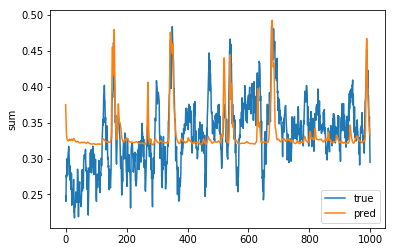

In [151]:
plot_comparison(start_idx=2, length=1000, train=False)